In [1]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch
from torchvision.transforms import Resize

### `Creating 2 functions, grabTrainingImages and grabTestingImages, both will be used to obtain image data`

In [13]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a resize transform
resizeTransform = Resize((128, 128))
trainImages = []
trainLabels = []

def grabTrainingImages(rootFolder, subsetAmount=0) -> None:
    """Grabs all the training images up to an amount

    Args:
        rootFolder (string): The root folder to start the grab from
        subsetAmount (int): How many folders of mammograms to process
        
    This function, at least in our case, will never process all folders since it takes roughly 10
    hours to process all 60,000 mammograms. Therefore, a subsetAmount can be passed to allow a 
    certain amount to be processed. If no subsetAmount is passed, the function will process all.
    """
    
    count = 1
    
    # Iterate through each folder in the root folder
    for folderName in os.listdir(rootFolder):
        folderPath = os.path.join(rootFolder, folderName)

        # Check if the current item is a folder
        if os.path.isdir(folderPath):
            print(f"Processing Folder Number {count}: {folderName}")
            # Call the function recursively to process subfolders
            grabTrainingImages(folderPath, subsetAmount)
            
            for filename in os.listdir(folderPath):                
                if filename.endswith(".dcm"):                    
                    ds = pydicom.dcmread(os.path.join(folderPath, filename))
                    image = ds.pixel_array.astype(float)
                    
                    # Convert the image to a PyTorch tensor and move it to the GPU if available
                    imgTensor = torch.tensor(image).unsqueeze(0).to(device)
                    # Resize the image
                    imgTensor = resizeTransform(imgTensor)
                    # Flatten to create feature vector
                    trainImages.append(imgTensor.view(-1).cpu().numpy())


                    # To view the image, uncomment next line
                    plt.imshow(image, cmap='gray'); plt.title(f"Patient ID: {folderName}"); plt.show()
            
            # If count reaches subsetAmount, it breaks the loop
            # If no subsetAmount is passed, it will never break since count start at 1, and subset is 0
            if count == subsetAmount:
                break
            
            # Print count either way to show progress
            count += 1

In [3]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a resize transform
resizeTransform = Resize((128, 128))
testImages = []
testLabels = []

def grabTestingImages(rootFolder) -> None:
    """Function for grabbing testing images

    Args:
        rootFolder (string): The root folder to start the grab from
        
    Although similar to grabTrainingImages, this function lacks the subset amount since the
    amount of testing image folders is not large, therefore a subset is never needed.
    Also, incorporating a case for if the folder is train_images or test_images would result
    in a lot of repeated code, so this function is created instead.
    """
    
    count = 1
    
    # Iterate through each folder in the root folder
    for folderName in os.listdir(rootFolder):
        folderPath = os.path.join(rootFolder, folderName)

        # Check if the current item is a folder
        if os.path.isdir(folderPath):
            print(f"Processing Testing Folder Number {count}: {folderName}")
            
            # Call the function recursively to process subfolders
            grabTestingImages(folderPath)
                        
            for filename in os.listdir(folderPath):                
                if filename.endswith(".dcm"):                    
                    ds = pydicom.dcmread(os.path.join(folderPath, filename))
                    image = ds.pixel_array.astype(float)
                    
                    # Convert the image to a PyTorch tensor and move it to the GPU if available
                    imgTensor = torch.tensor(image).unsqueeze(0).to(device)
                    # Resize the image
                    imgTensor = resizeTransform(imgTensor)
                    # Flatten to create feature vector
                    testImages.append(imgTensor.view(-1).cpu().numpy())
                    testLabels.append(folderName)
                    
                    plt.imshow(image, cmap='gray'); plt.title(f"Patient ID: {folderName}"); plt.show()

                    
        count += 1


### `Running the functions to grab the needed data`

Processing Folder Number 1: 10006


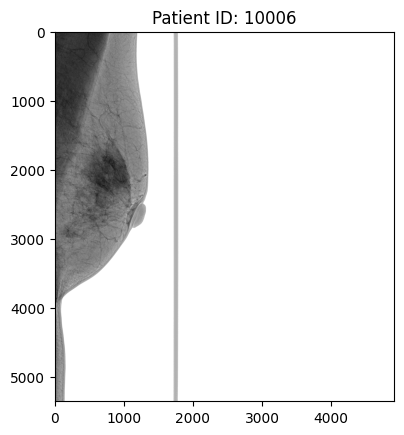

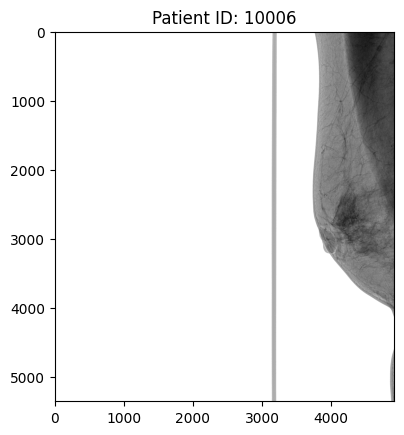

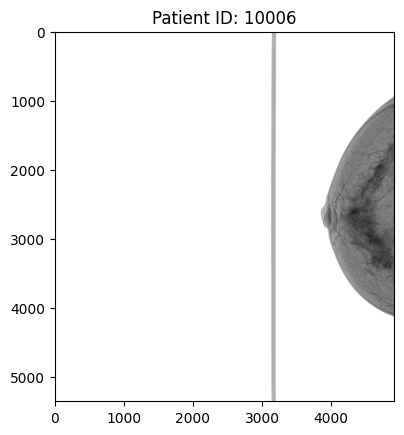

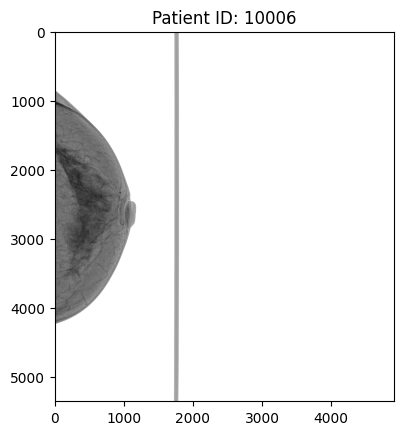

Processing Folder Number 2: 10011


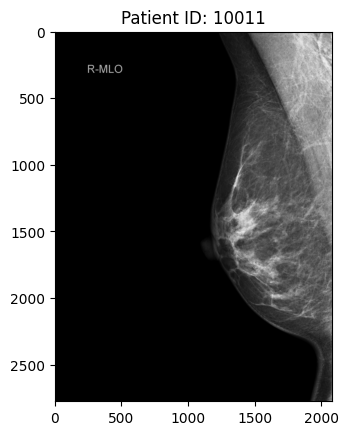

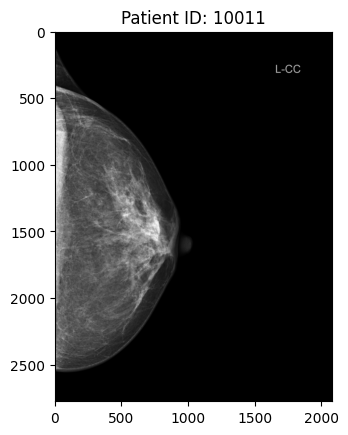

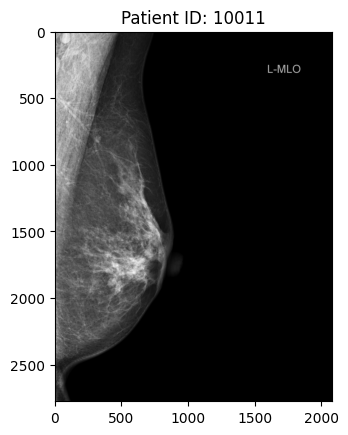

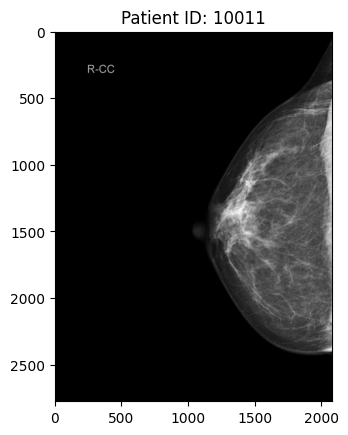

Processing Folder Number 3: 10025


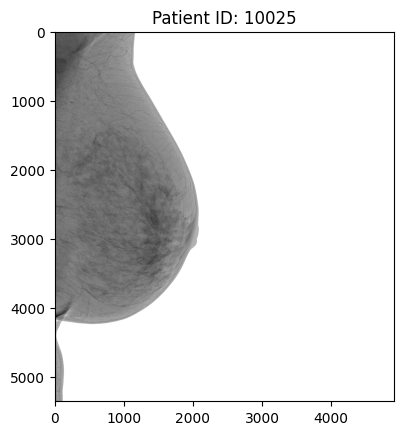

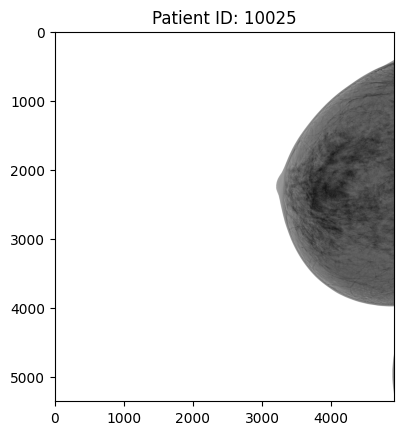

KeyboardInterrupt: 

In [14]:
# Specify the root folder with or without subfolders 
trainImagesPath = "C:\\Users\\vange\\OneDrive - Tennessee Tech University\\Desktop\\Fall 23, Spring 24\\4260\\mammography\\train_images"
#testImagesPath = "C:\\Users\\vange\\OneDrive - Tennessee Tech University\\Desktop\\Fall 23, Spring 24\\4260\\mammography\\test_images"

# Change this to the amount of folders you want to process
subsetAmount = 20

# Used for grabbing training data (many folders, needs subset, if you don't pass a subset amount, it will process all folders)
grabTrainingImages(trainImagesPath, subsetAmount)

# Used for grabbing testing data (less folders, no need for subset)
#grabTestingImages(testImagesPath)

### `Convert the images to a numpy array, this allows the svm to learn based off`
### `the patterns in the images related to cancer`

In [152]:
len(trainLabels)

94

In [153]:
xTrain = np.array(trainImages)
xTest = np.array(testImages)

trainData = pd.read_csv("C:\\Users\\vange\\OneDrive - Tennessee Tech University\\Desktop\\Fall 23, Spring 24\\4260\\mammography\\Mammography\\train.csv")
testData = pd.read_csv("C:\\Users\\vange\\OneDrive - Tennessee Tech University\\Desktop\\Fall 23, Spring 24\\4260\\mammography\\Mammography\\test.csv")

# yTrain is the label -> cancer
yTrain = np.array(trainLabels)

# What labels will be used for yTest?
yTest = np.array(testLabels)

print(f"xTrain.shape: {xTrain.shape}, yTrain.shape: {yTrain.shape}")
print(f"xTest.shape: {xTest.shape}, yTest.shape: {yTest.shape}") 

xTrain.shape: (94, 16384), yTrain.shape: (94,)
xTest.shape: (12, 16384), yTest.shape: (12,)


#### `Following, we train the svm using a linear kernel since we are trying to find if a breast is cancerous`
#### `or not, meaning a linearlly seperable answer, being cancerous or non cancerous. Then, we predict using`
#### `the test data from above, and then that will be used on the yTest data to check for accuracy`

In [154]:
# Train SVM model
svm = SVC(kernel='linear')
svm.fit(xTrain, yTrain)

SVC(kernel='linear')

In [155]:
# Predict on the xTest data and store it in yPred for scoring later
yPred = svm.predict(xTest)

In [160]:
yPred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [156]:
# Evaluate model

# Not quite working yet!

accuracy = accuracy_score(yTest, yPred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.0


## `Once the model works properly, I wish to add visualizations below`